In [1]:
import numpy as np
import datetime as dt
import astropy.units as u
import time
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
from sunpy.coordinates.sun import carrington_rotation_time
import astropy.constants as const
import sunpy.map
import os
import pfsspy
from pfsspy import tracing
from model_chain import get_ace_date, pfss2flines, distance_to_coronal_hole_boundary, run_chain_of_models

In [2]:
import matplotlib.dates as mdates

import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['savefig.facecolor'] = 'white'
font = {'family': 'serif',
        'size': 12}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

In [3]:
def compute_pfss(br, ACE_longitude, ACE_latitude, CR, r_ss=2.5, n_r_pfss=100, n_theta_ch=180, n_phi_ch=360):
    # PFSS simulate.
    pfss_in = pfsspy.Input(br=br, nr=n_r_pfss, rss=r_ss)
    pfss_out = pfsspy.pfss(input=pfss_in)

    # trace the magnetic field lines for the ACE projection to obtain the magnetic expansion factor.
    tracer = tracing.FortranTracer()
    seeds = SkyCoord(ACE_longitude.to(u.rad),
                     ACE_latitude.to(u.rad),
                     r_ss * const.R_sun,
                     frame=pfss_out.coordinate_frame)
    field_lines_fp = tracer.trace(seeds=seeds, output=pfss_out)
    # expansion factor
    fp_ace_traj = field_lines_fp.expansion_factors

    # coronal hole mapping
    topologies = pfss2flines(pfsspy_out=pfss_out, nth=n_theta_ch, nph=n_phi_ch)
    d_ace_traj = distance_to_coronal_hole_boundary(topologies=topologies, field_lines_fp=field_lines_fp)
    
    # make dir 
    new_dir = os.getcwd() + "/PFSS/CR"+ str(CR) + "/"
    # if not exist then make
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    
    # save solution in dir
    np.save(file=new_dir + "/distance_to_coronal_hole", arr=d_ace_traj)
    np.save(file=new_dir + "/expansion_factor", arr=fp_ace_traj)

# get data

In [4]:
# get data
# exclude 2051 since there were 3 CMEs during this time period.
list_of_carrington_rotations = [2048, 2049, 2050, 2052, 2053, 2054, 2055, 2056, 2057, 2058]
num_cr = len(list_of_carrington_rotations)
ACE_longitude_list = []
ACE_latitude_list = []
gong_map_list = []

In [5]:
for cr in list_of_carrington_rotations:
    # get ace data
    start_time = carrington_rotation_time(int(cr)).to_datetime()
    end_time = carrington_rotation_time(int(cr) + 1).to_datetime()
    result = get_ace_date(start_time=start_time, end_time=end_time)
    ACE_longitude_list.append(result[0])
    ACE_latitude_list.append(result[1])

    # get gong synoptic maps
    gong = sunpy.map.Map('GONG/CR' + str(cr) + '/cr' + str(cr) + '.fits.gz')
    gong.meta["bunit"] = u.gauss
    gong.meta["DATE"] = str(result[4][-1])
    gong.meta["DATE_OBS"] = str(result[4][-1])
    gong_map_list.append(gong)

# compute PFSS results

In [6]:
for ii in range(len(list_of_carrington_rotations)):
    compute_pfss(br=gong_map_list[ii], 
                 ACE_longitude=ACE_longitude_list[ii], 
                 ACE_latitude=ACE_latitude_list[ii], 
                 CR=list_of_carrington_rotations[ii])

Observatory,NSO-GONG
Instrument,
Detector,
Measurement,676.8
Wavelength,676.8
Observation Date,2007-07-26 23:54:00
Exposure Time,Unknown
Dimension,[360. 180.] pix
Coordinate System,heliographic_carrington
Scale,[1. 0.63661914] deg / pix
Reference Pixel,[179.5 89.5] pix

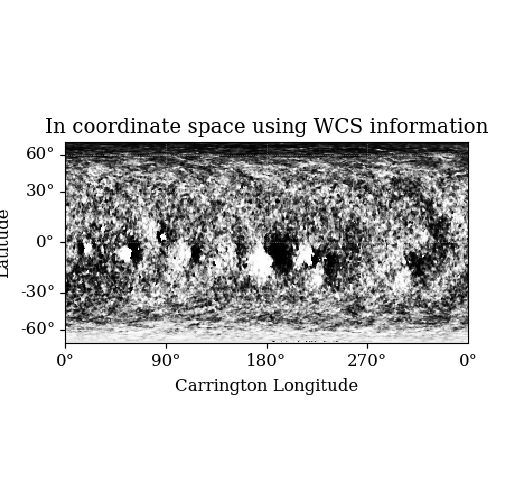
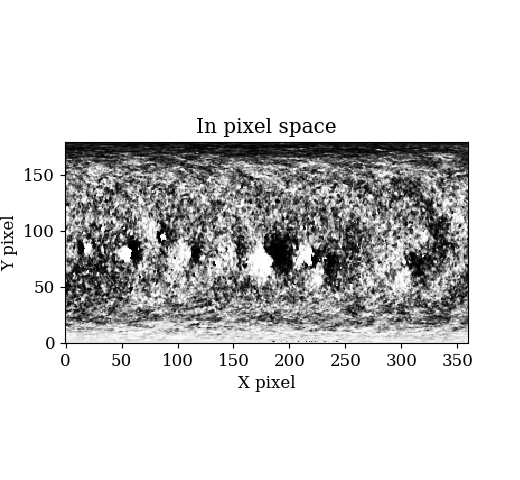
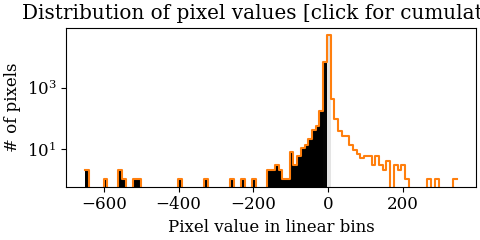
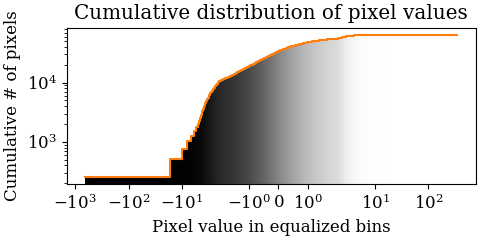

In [8]:
gong_map_list[ii]